In [1]:
#import sys
#!{sys.executable} -m pip install --quiet gensim
#!{sys.executable} -m pip install bs4

In [44]:
#Loading all required libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import seaborn as sns
import multiprocessing
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from functools import reduce

In [ ]:
plt.style.use('fivethirtyeight')

In [19]:
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

In [20]:
def clean_yelp(s):
    s = BeautifulSoup(s, 'html.parser').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(s)

In [21]:
vectorizer_yelp = CountVectorizer(preprocessor=clean_yelp,tokenizer=tokenize) 
TF_yelp         = vectorizer_yelp.fit_transform(yelps.text)
trun            = TruncatedSVD(n_components=100)
PCA_yelp        = trun.fit_transform(TF_yelp)

/anaconda3/envs/MT/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/envs/MT/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [22]:
def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [27]:
cutoff = []
for cut in np.arange(0.05, 0.5, 0.025):
    cutoff.append(int(len(yelps.positive)*cut))
    
accuracy_TF_yelp  = [test_holdout_vectors(TF_yelp, yelps.positive, c) 
             for c in cutoff]

accuracy_PCA_yelp = [test_holdout_vectors(PCA_yelp, yelps.positive, c) 
             for c in cutoff] 

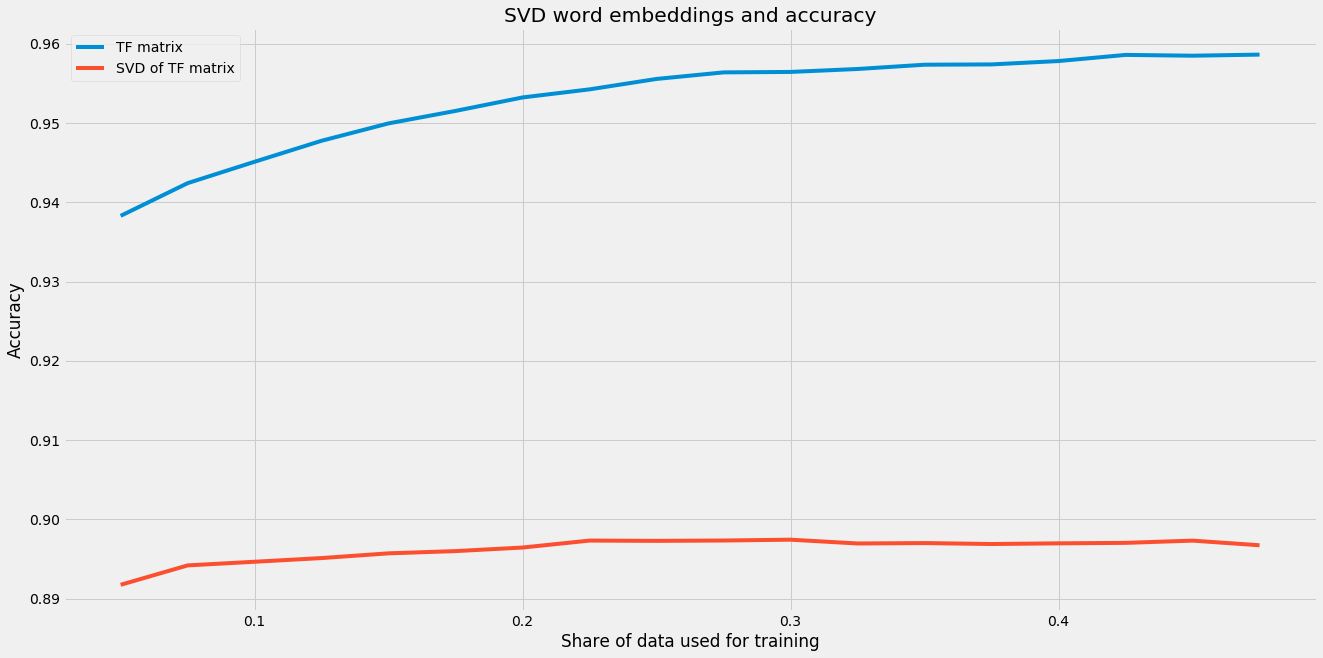

In [79]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.tick_params(axis = 'both', which = 'major')
plt.legend(['TF matrix','SVD of TF matrix'])
plt.xlabel('Share of data used for training')
plt.title('SVD word embeddings and accuracy')
plt.ylabel('Accuracy')
plt.show()

We see that the word embeddings generated via SVD do not improve accuracy.

In [31]:
cores = multiprocessing.cpu_count()
sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model     = Word2Vec(sentences, window=5, min_count=5, workers=cores-1) 

/anaconda3/envs/MT/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/envs/MT/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [32]:
def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0) #fixed to add summation
    a /= np.linalg.norm(a)
    return a

In [33]:
w2v_matrix    = np.array([embed_w2v(t, model) for t in sentences])
accuracy_w2v = [test_holdout_vectors(w2v_matrix, yelps.positive, c) for c in cutoff]

In [35]:
def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a

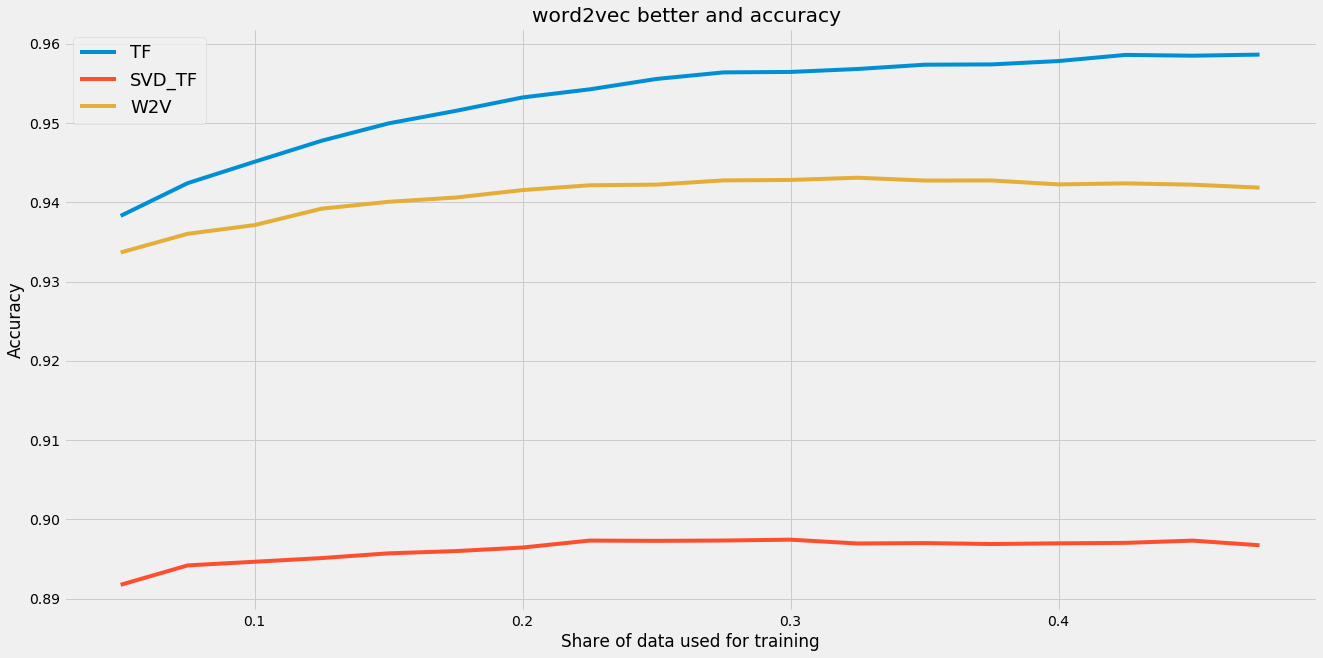

In [74]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v)
plt.tick_params(axis = 'both', which = 'major')
plt.legend(['TF','SVD_TF','W2V'],fontsize=18)
plt.xlabel('Share of data used for training')
plt.title('word2vec better and accuracy ')
plt.ylabel('Accuracy')
plt.show()

Word2vec is not better in this example.

In [37]:
def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    
    # remove twitter handles (@user); URLs; RT; and random punctuation
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    
    # keep only words
    s = re.sub("[^a-zA-Z]", " ", s)

    return s

In [39]:
# Load tweet!
 
with open('tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [40]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

vectorizer_yelp = CountVectorizer(preprocessor=clean_twitter)
TF_tweets       = vectorizer_yelp.fit_transform(tweets)

trun2      = TruncatedSVD(n_components=100)
PCA_tweets = trun2.fit_transform(TF_tweets)

sentences2  = [clean_twitter(t).split(' ') for t in tweets]
model_tweet = Word2Vec(sentences2, window=5, min_count=2, workers=cores-1)
# model.train(sentences2,total_examples=len(sentences2),epochs=10)
#embeddings
w2v_tweets  = np.array([embed_w2v(t, model_tweet) for t in sentences2])

In [73]:
print("'trump' is found:")
print(model_tweet.wv.most_similar (positive="trump",topn=2))
print()
print("'hillary' is found:")
print(model_tweet.wv.most_similar (positive="hillary",topn=2))
print()
print("'what democrat is to hillary is to trump:")
print(model_tweet.wv.most_similar(positive=["democrat", "hillary"], negative=["trump"],topn=2))

'trump' is found:
[('Trump', 0.6986191272735596), ('Trumps', 0.5908395648002625)]

'hillary' is found:
[('Killary', 0.6210411190986633), ('Hitlery', 0.5918024182319641)]

'what democrat is to hillary is to trump:
[('dysfunctional', 0.5401344299316406), ('flawed', 0.5342169404029846)]


In [42]:
def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

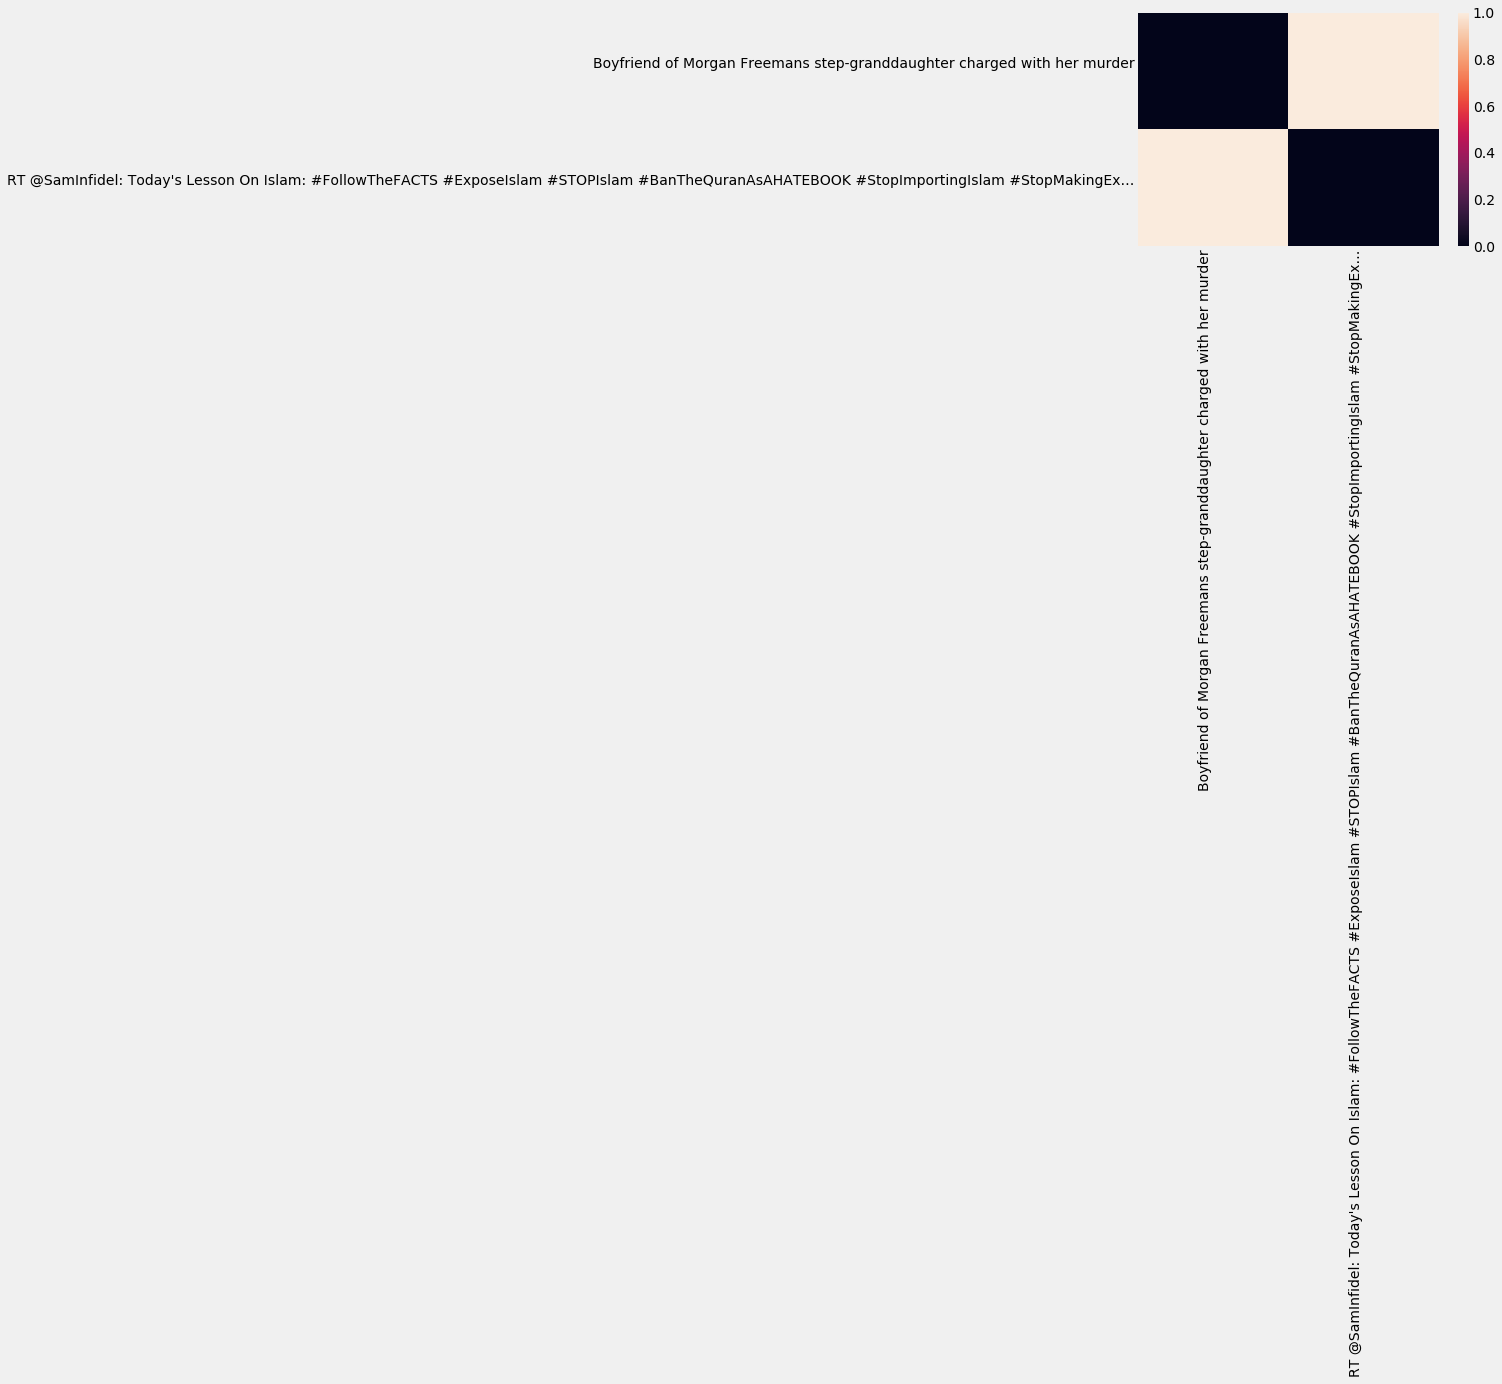

In [72]:
idx = np.random.randint(0, high=len(tweets), size=2)
visualize_dist(PCA_tweets, tweets, idx)

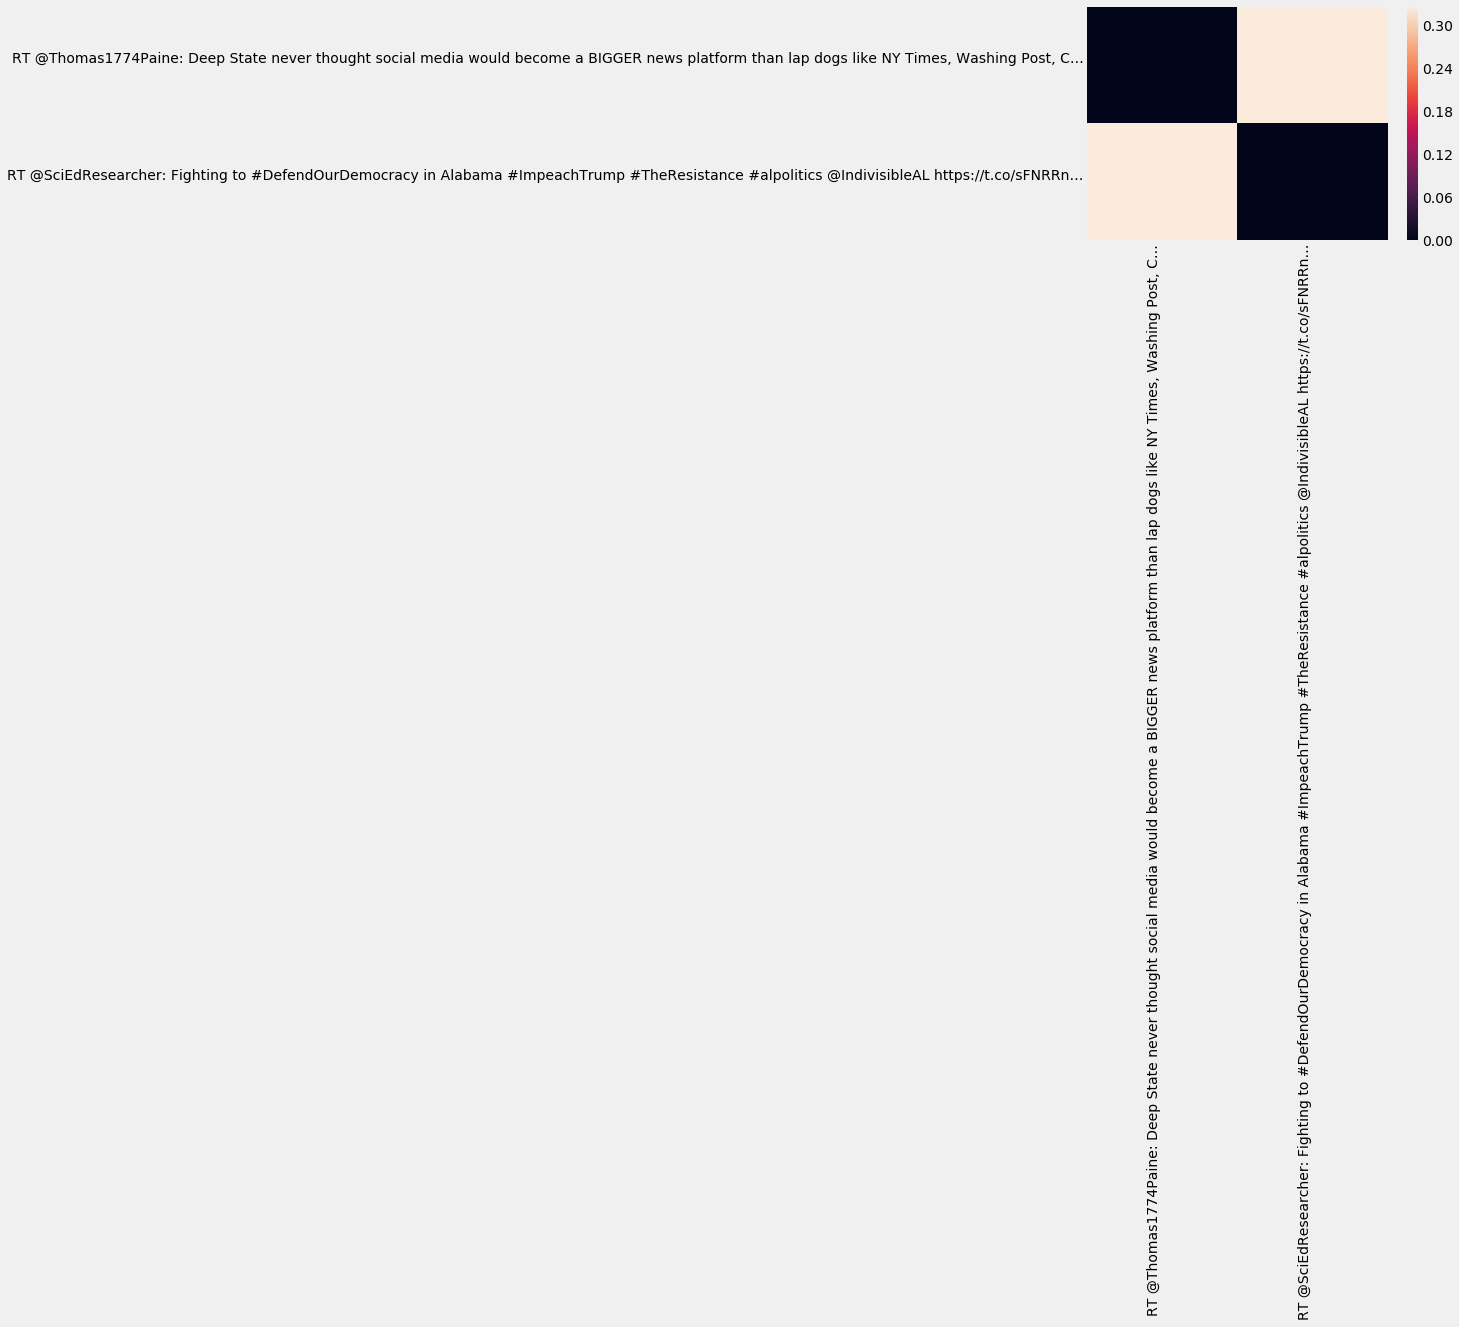

In [64]:
visualize_dist(w2v_tweets, tweets, idx)

# Bonus

In [47]:
import gensim.downloader as api
model_google = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/anaconda3/envs/MT/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [71]:
model_google.vector_size

300

In [49]:
w2v_matrix_google   = np.array([embed_w2v(t, model_google) for t in sentences])
accuracy_w2v_google = [test_holdout_vectors(w2v_matrix_google, yelps.positive, c) for c in cutoff]

/anaconda3/envs/MT/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/anaconda3/envs/MT/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/anaconda3/envs/MT/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


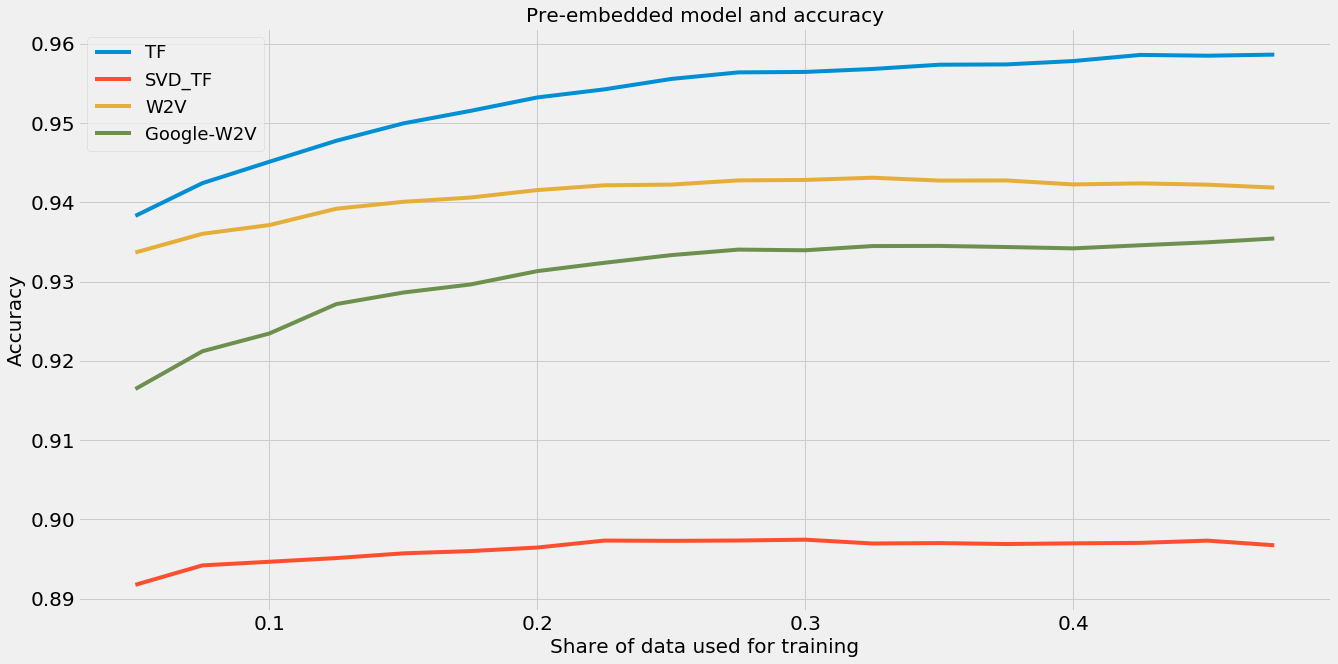

In [70]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_TF_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_PCA_yelp)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v)
plt.plot(np.arange(0.05, 0.5, 0.025),accuracy_w2v_google)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(['TF','SVD_TF','W2V','Google-W2V'],fontsize=18)
plt.xlabel('Share of data used for training',fontsize=20)
plt.title('Pre-embedded model and accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.show()

Now, we see that the pre-embedded model helps somewhat. 